In [39]:
# 模型思路
# 1 KNN找出距离非常近的点
# 2 剩下的用树模型来拟合

In [56]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm


In [57]:

train = pd.read_csv('d_train_20180102.csv',encoding='gbk')
test = pd.read_csv('d_test_A_20180102.csv',encoding='gbk')

print('train shape',train.shape)
print('test shape',test.shape)

train shape (5642, 42)
test shape (1000, 41)


In [58]:
# *天门冬氨酸氨基转换酶 和 *丙氨酸氨基转换酶 相关性高，同时后者对血糖相关性要高于前者，故删除前者
# 同理 低密度脂蛋白胆固醇>总胆固醇
# 血红蛋白>红细胞计数、红细胞压积 以后可考虑用综合指标
#drop_list = ['*天门冬氨酸氨基转换酶','总胆固醇','id','*总蛋白','白球比例','红细胞压积','红细胞计数',
            #'红细胞平均体积','血小板比积','淋巴细胞%','体检日期']
drop_list = ['体检日期','id']
train.drop(drop_list,inplace=True,axis=1)
test.drop(drop_list,inplace=True,axis=1)
#train.fillna(-9999, inplace=True)
#test.fillna(-9999, inplace=True)

In [59]:
# 查看缺失值比例
#data = pd.concat([train,test],axis=0)
#print(data.isnull().sum()/len(data))

In [60]:
sex_map = {'男':1,'女':0,'??':0}
x = train.drop(['血糖'],axis=1)
x['性别'] = x['性别'].map(sex_map)
test['性别'] = test['性别'].map(sex_map)

y = train['血糖']
x = x.values

In [61]:
# Keep list of all categorical features in dataset to specify this for CatBoost
cat_features_ids = np.where(train.apply(pd.Series.nunique) < 30000)[0].tolist()

In [62]:
# 根据年龄、性别进行分类
train.apply(pd.Series.nunique)

性别                3
年龄               76
*天门冬氨酸氨基转换酶    2164
*丙氨酸氨基转换酶      2766
*碱性磷酸酶         3432
*r-谷氨酰基转换酶     3063
*总蛋白           1527
白蛋白            1088
*球蛋白           1390
白球比例            143
甘油三酯            534
总胆固醇            524
高密度脂蛋白胆固醇       191
低密度脂蛋白胆固醇       457
尿素              630
肌酐             1841
尿酸             3995
乙肝表面抗原           87
乙肝表面抗体          793
乙肝e抗原            41
乙肝e抗体           375
乙肝核心抗体          442
白细胞计数           785
红细胞计数           292
血红蛋白            353
红细胞压积           256
红细胞平均体积         315
红细胞平均血红蛋白量      175
红细胞平均血红蛋白浓度     101
红细胞体积分布宽度        90
血小板计数           359
血小板平均体积          75
血小板体积分布宽度       142
血小板比积           180
中性粒细胞%          444
淋巴细胞%           410
单核细胞%           114
嗜酸细胞%           124
嗜碱细胞%            27
血糖              611
dtype: int64

In [89]:
param = {}
#param['objective'] = 'multi:softprob'
param['eta'] = 0.1  
param['max_depth'] = 3
param['silent'] = 1  
#param['num_class'] = 2
# param['scale_pos_weight'] = 3
param['learning_rate'] = 0.01
param['nthread'] = 7
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
num_round = 5000

In [64]:
real_test = xgb.DMatrix(test.values) 

In [53]:
#y = np.array([y[i]  if y[i] <15 else 15 for i in range(len(y))])

In [92]:
from sklearn import metrics
kfolds = 10
result = np.zeros((kfolds,len(test)))
kf = KFold(n_splits=kfolds,shuffle=True,random_state=2016)
i = 0
temp = []
for train_index,test_index in kf.split(x):
    print(train_index)
    X_train, X_test = x[train_index], x[test_index]
    
    y_train, y_test = y[train_index], y[test_index]
    y_train = y_train.clip_upper(15)
    
    xg_train = xgb.DMatrix(X_train, label = y_train) 
    xg_test = xgb.DMatrix(X_test, label = y_test) 
    watchlist = [(xg_train, 'train'), (xg_test, 'val')]
    bst = xgb.train(param, xg_train, num_round,watchlist, early_stopping_rounds = 100)
    y_ = bst.predict(xg_test)
    #

    mse = metrics.mean_squared_error(y_,y_test)/2
    temp.append(mse)
    print(mse)
    result[i,:]=bst.predict(real_test)
    i += 1

[   0    2    3 ..., 5639 5640 5641]
[0]	train-rmse:5.25328	val-rmse:5.31432
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5.20414	val-rmse:5.26552
[2]	train-rmse:5.15553	val-rmse:5.21714
[3]	train-rmse:5.10743	val-rmse:5.16916
[4]	train-rmse:5.05984	val-rmse:5.1218
[5]	train-rmse:5.01276	val-rmse:5.07474
[6]	train-rmse:4.96618	val-rmse:5.02838
[7]	train-rmse:4.92009	val-rmse:4.98232
[8]	train-rmse:4.87449	val-rmse:4.93696
[9]	train-rmse:4.82938	val-rmse:4.89188
[10]	train-rmse:4.78475	val-rmse:4.84729
[11]	train-rmse:4.7406	val-rmse:4.8034
[12]	train-rmse:4.69692	val-rmse:4.75976
[13]	train-rmse:4.65371	val-rmse:4.71678
[14]	train-rmse:4.61096	val-rmse:4.67406
[15]	train-rmse:4.56867	val-rmse:4.63199
[16]	train-rmse:4.52684	val-rmse:4.5902
[17]	train-rmse:4.48543	val-rmse:4.54915
[18]	train-rmse:4.44449	val-rmse:4.50824
[19]	train-rmse:4.40397	val-rmse:4.46806
[20]	train-rmse

[195]	train-rmse:1.43305	val-rmse:1.54257
[196]	train-rmse:1.42903	val-rmse:1.5389
[197]	train-rmse:1.42516	val-rmse:1.53543
[198]	train-rmse:1.42133	val-rmse:1.53174
[199]	train-rmse:1.41744	val-rmse:1.52786
[200]	train-rmse:1.41363	val-rmse:1.52441
[201]	train-rmse:1.41009	val-rmse:1.52104
[202]	train-rmse:1.40656	val-rmse:1.51776
[203]	train-rmse:1.40282	val-rmse:1.51461
[204]	train-rmse:1.39935	val-rmse:1.5115
[205]	train-rmse:1.39593	val-rmse:1.50821
[206]	train-rmse:1.39245	val-rmse:1.50509
[207]	train-rmse:1.38902	val-rmse:1.50168
[208]	train-rmse:1.38571	val-rmse:1.49862
[209]	train-rmse:1.3824	val-rmse:1.49561
[210]	train-rmse:1.37925	val-rmse:1.49283
[211]	train-rmse:1.37623	val-rmse:1.4899
[212]	train-rmse:1.3732	val-rmse:1.48683
[213]	train-rmse:1.37	val-rmse:1.48421
[214]	train-rmse:1.36701	val-rmse:1.48146
[215]	train-rmse:1.36404	val-rmse:1.4788
[216]	train-rmse:1.36113	val-rmse:1.47612
[217]	train-rmse:1.3583	val-rmse:1.47362
[218]	train-rmse:1.35542	val-rmse:1.4709
[21

[392]	train-rmse:1.17257	val-rmse:1.32189
[393]	train-rmse:1.17212	val-rmse:1.32161
[394]	train-rmse:1.17165	val-rmse:1.32158
[395]	train-rmse:1.17128	val-rmse:1.3214
[396]	train-rmse:1.17095	val-rmse:1.32124
[397]	train-rmse:1.17044	val-rmse:1.32113
[398]	train-rmse:1.17014	val-rmse:1.32096
[399]	train-rmse:1.16979	val-rmse:1.32079
[400]	train-rmse:1.16944	val-rmse:1.32062
[401]	train-rmse:1.16908	val-rmse:1.32056
[402]	train-rmse:1.16865	val-rmse:1.32023
[403]	train-rmse:1.16834	val-rmse:1.32018
[404]	train-rmse:1.16808	val-rmse:1.3201
[405]	train-rmse:1.16774	val-rmse:1.31978
[406]	train-rmse:1.16726	val-rmse:1.31969
[407]	train-rmse:1.16694	val-rmse:1.31931
[408]	train-rmse:1.16652	val-rmse:1.319
[409]	train-rmse:1.16611	val-rmse:1.31876
[410]	train-rmse:1.16564	val-rmse:1.31868
[411]	train-rmse:1.16534	val-rmse:1.31858
[412]	train-rmse:1.16508	val-rmse:1.31841
[413]	train-rmse:1.16474	val-rmse:1.31826
[414]	train-rmse:1.16442	val-rmse:1.31811
[415]	train-rmse:1.164	val-rmse:1.3178

[588]	train-rmse:1.11506	val-rmse:1.30174
[589]	train-rmse:1.11488	val-rmse:1.30167
[590]	train-rmse:1.11476	val-rmse:1.30158
[591]	train-rmse:1.1145	val-rmse:1.30169
[592]	train-rmse:1.11429	val-rmse:1.30171
[593]	train-rmse:1.11405	val-rmse:1.3013
[594]	train-rmse:1.11392	val-rmse:1.30124
[595]	train-rmse:1.11378	val-rmse:1.30107
[596]	train-rmse:1.11367	val-rmse:1.30102
[597]	train-rmse:1.11346	val-rmse:1.30091
[598]	train-rmse:1.11334	val-rmse:1.30085
[599]	train-rmse:1.11309	val-rmse:1.3009
[600]	train-rmse:1.11295	val-rmse:1.30091
[601]	train-rmse:1.11273	val-rmse:1.30085
[602]	train-rmse:1.1124	val-rmse:1.30062
[603]	train-rmse:1.11215	val-rmse:1.30071
[604]	train-rmse:1.11189	val-rmse:1.30079
[605]	train-rmse:1.11172	val-rmse:1.30061
[606]	train-rmse:1.1114	val-rmse:1.30046
[607]	train-rmse:1.11114	val-rmse:1.30025
[608]	train-rmse:1.11087	val-rmse:1.30036
[609]	train-rmse:1.11075	val-rmse:1.30029
[610]	train-rmse:1.11057	val-rmse:1.30023
[611]	train-rmse:1.11046	val-rmse:1.300

[785]	train-rmse:1.07887	val-rmse:1.28961
[786]	train-rmse:1.07879	val-rmse:1.28959
[787]	train-rmse:1.07859	val-rmse:1.28967
[788]	train-rmse:1.07837	val-rmse:1.2896
[789]	train-rmse:1.07831	val-rmse:1.28956
[790]	train-rmse:1.07826	val-rmse:1.28958
[791]	train-rmse:1.07816	val-rmse:1.28955
[792]	train-rmse:1.07793	val-rmse:1.28952
[793]	train-rmse:1.07779	val-rmse:1.28951
[794]	train-rmse:1.07754	val-rmse:1.28952
[795]	train-rmse:1.07732	val-rmse:1.28955
[796]	train-rmse:1.07714	val-rmse:1.28962
[797]	train-rmse:1.07695	val-rmse:1.28961
[798]	train-rmse:1.0769	val-rmse:1.28963
[799]	train-rmse:1.07673	val-rmse:1.28964
[800]	train-rmse:1.07659	val-rmse:1.28963
[801]	train-rmse:1.0765	val-rmse:1.2896
[802]	train-rmse:1.07633	val-rmse:1.28957
[803]	train-rmse:1.07623	val-rmse:1.2897
[804]	train-rmse:1.07614	val-rmse:1.28961
[805]	train-rmse:1.07591	val-rmse:1.28956
[806]	train-rmse:1.07583	val-rmse:1.28954
[807]	train-rmse:1.07578	val-rmse:1.28949
[808]	train-rmse:1.07563	val-rmse:1.289

[62]	train-rmse:3.02421	val-rmse:3.46927
[63]	train-rmse:2.99944	val-rmse:3.44706
[64]	train-rmse:2.97499	val-rmse:3.42526
[65]	train-rmse:2.95078	val-rmse:3.40376
[66]	train-rmse:2.9269	val-rmse:3.38261
[67]	train-rmse:2.90323	val-rmse:3.3616
[68]	train-rmse:2.87987	val-rmse:3.34082
[69]	train-rmse:2.85678	val-rmse:3.32041
[70]	train-rmse:2.834	val-rmse:3.30037
[71]	train-rmse:2.81142	val-rmse:3.2804
[72]	train-rmse:2.78913	val-rmse:3.26082
[73]	train-rmse:2.76711	val-rmse:3.2416
[74]	train-rmse:2.74532	val-rmse:3.22251
[75]	train-rmse:2.72386	val-rmse:3.20383
[76]	train-rmse:2.70263	val-rmse:3.18527
[77]	train-rmse:2.68163	val-rmse:3.16703
[78]	train-rmse:2.66086	val-rmse:3.1489
[79]	train-rmse:2.64037	val-rmse:3.13126
[80]	train-rmse:2.6201	val-rmse:3.11374
[81]	train-rmse:2.60007	val-rmse:3.09638
[82]	train-rmse:2.58036	val-rmse:3.07946
[83]	train-rmse:2.5608	val-rmse:3.06254
[84]	train-rmse:2.54149	val-rmse:3.04591
[85]	train-rmse:2.52244	val-rmse:3.02961
[86]	train-rmse:2.50359	v

[260]	train-rmse:1.2627	val-rmse:2.06092
[261]	train-rmse:1.26117	val-rmse:2.06006
[262]	train-rmse:1.25967	val-rmse:2.05929
[263]	train-rmse:1.25831	val-rmse:2.05855
[264]	train-rmse:1.25684	val-rmse:2.05756
[265]	train-rmse:1.2554	val-rmse:2.05684
[266]	train-rmse:1.25411	val-rmse:2.05607
[267]	train-rmse:1.2528	val-rmse:2.0552
[268]	train-rmse:1.25142	val-rmse:2.05433
[269]	train-rmse:1.25005	val-rmse:2.05339
[270]	train-rmse:1.24866	val-rmse:2.05272
[271]	train-rmse:1.24733	val-rmse:2.052
[272]	train-rmse:1.24603	val-rmse:2.05135
[273]	train-rmse:1.24462	val-rmse:2.05072
[274]	train-rmse:1.24346	val-rmse:2.04988
[275]	train-rmse:1.24221	val-rmse:2.04913
[276]	train-rmse:1.2409	val-rmse:2.04847
[277]	train-rmse:1.23981	val-rmse:2.04782
[278]	train-rmse:1.23861	val-rmse:2.04725
[279]	train-rmse:1.23737	val-rmse:2.04669
[280]	train-rmse:1.2362	val-rmse:2.04608
[281]	train-rmse:1.23505	val-rmse:2.04558
[282]	train-rmse:1.23391	val-rmse:2.04496
[283]	train-rmse:1.23287	val-rmse:2.04426


[457]	train-rmse:1.13936	val-rmse:2.0047
[458]	train-rmse:1.13905	val-rmse:2.0045
[459]	train-rmse:1.13888	val-rmse:2.00434
[460]	train-rmse:1.13854	val-rmse:2.00439
[461]	train-rmse:1.13827	val-rmse:2.00422
[462]	train-rmse:1.13801	val-rmse:2.00416
[463]	train-rmse:1.13779	val-rmse:2.00407
[464]	train-rmse:1.13746	val-rmse:2.00407
[465]	train-rmse:1.1372	val-rmse:2.00388
[466]	train-rmse:1.1369	val-rmse:2.00378
[467]	train-rmse:1.13646	val-rmse:2.00387
[468]	train-rmse:1.13621	val-rmse:2.00382
[469]	train-rmse:1.13597	val-rmse:2.00372
[470]	train-rmse:1.13556	val-rmse:2.00341
[471]	train-rmse:1.13527	val-rmse:2.00327
[472]	train-rmse:1.13492	val-rmse:2.00326
[473]	train-rmse:1.1346	val-rmse:2.00332
[474]	train-rmse:1.13434	val-rmse:2.00309
[475]	train-rmse:1.134	val-rmse:2.00303
[476]	train-rmse:1.13372	val-rmse:2.00294
[477]	train-rmse:1.13357	val-rmse:2.00278
[478]	train-rmse:1.13332	val-rmse:2.00262
[479]	train-rmse:1.13306	val-rmse:2.00259
[480]	train-rmse:1.13272	val-rmse:2.00253

[654]	train-rmse:1.09088	val-rmse:1.99406
[655]	train-rmse:1.09057	val-rmse:1.99397
[656]	train-rmse:1.09039	val-rmse:1.99388
[657]	train-rmse:1.09026	val-rmse:1.99382
[658]	train-rmse:1.0901	val-rmse:1.99382
[659]	train-rmse:1.08992	val-rmse:1.99381
[660]	train-rmse:1.08966	val-rmse:1.99379
[661]	train-rmse:1.08945	val-rmse:1.99357
[662]	train-rmse:1.08932	val-rmse:1.99353
[663]	train-rmse:1.08913	val-rmse:1.99353
[664]	train-rmse:1.08895	val-rmse:1.99351
[665]	train-rmse:1.08872	val-rmse:1.99348
[666]	train-rmse:1.08844	val-rmse:1.99347
[667]	train-rmse:1.08814	val-rmse:1.99339
[668]	train-rmse:1.08796	val-rmse:1.99341
[669]	train-rmse:1.08772	val-rmse:1.99338
[670]	train-rmse:1.08756	val-rmse:1.99338
[671]	train-rmse:1.08735	val-rmse:1.99341
[672]	train-rmse:1.08726	val-rmse:1.99325
[673]	train-rmse:1.08708	val-rmse:1.99315
[674]	train-rmse:1.08691	val-rmse:1.99314
[675]	train-rmse:1.08668	val-rmse:1.99312
[676]	train-rmse:1.08652	val-rmse:1.99303
[677]	train-rmse:1.08633	val-rmse:1

[851]	train-rmse:1.05625	val-rmse:1.98868
[852]	train-rmse:1.05613	val-rmse:1.98864
[853]	train-rmse:1.05594	val-rmse:1.98855
[854]	train-rmse:1.05582	val-rmse:1.98852
[855]	train-rmse:1.05566	val-rmse:1.98852
[856]	train-rmse:1.0554	val-rmse:1.98841
[857]	train-rmse:1.05527	val-rmse:1.98838
[858]	train-rmse:1.05507	val-rmse:1.98842
[859]	train-rmse:1.05495	val-rmse:1.98844
[860]	train-rmse:1.0549	val-rmse:1.98845
[861]	train-rmse:1.0548	val-rmse:1.98842
[862]	train-rmse:1.05464	val-rmse:1.98842
[863]	train-rmse:1.05442	val-rmse:1.98843
[864]	train-rmse:1.05426	val-rmse:1.98831
[865]	train-rmse:1.05421	val-rmse:1.98832
[866]	train-rmse:1.05399	val-rmse:1.98832
[867]	train-rmse:1.0538	val-rmse:1.98834
[868]	train-rmse:1.05371	val-rmse:1.98835
[869]	train-rmse:1.05345	val-rmse:1.98824
[870]	train-rmse:1.05321	val-rmse:1.98827
[871]	train-rmse:1.05313	val-rmse:1.98827
[872]	train-rmse:1.05302	val-rmse:1.98827
[873]	train-rmse:1.05289	val-rmse:1.98832
[874]	train-rmse:1.05267	val-rmse:1.98

[1046]	train-rmse:1.02892	val-rmse:1.98432
[1047]	train-rmse:1.0288	val-rmse:1.98432
[1048]	train-rmse:1.02858	val-rmse:1.98434
[1049]	train-rmse:1.02849	val-rmse:1.98435
[1050]	train-rmse:1.02841	val-rmse:1.98435
[1051]	train-rmse:1.02833	val-rmse:1.98431
[1052]	train-rmse:1.02826	val-rmse:1.98425
[1053]	train-rmse:1.02816	val-rmse:1.98422
[1054]	train-rmse:1.02801	val-rmse:1.98416
[1055]	train-rmse:1.02797	val-rmse:1.98416
[1056]	train-rmse:1.02781	val-rmse:1.98417
[1057]	train-rmse:1.02775	val-rmse:1.98417
[1058]	train-rmse:1.02766	val-rmse:1.98416
[1059]	train-rmse:1.02756	val-rmse:1.98418
[1060]	train-rmse:1.02738	val-rmse:1.98417
[1061]	train-rmse:1.02718	val-rmse:1.98425
[1062]	train-rmse:1.02711	val-rmse:1.98423
[1063]	train-rmse:1.02694	val-rmse:1.98416
[1064]	train-rmse:1.02681	val-rmse:1.98415
[1065]	train-rmse:1.02672	val-rmse:1.98416
[1066]	train-rmse:1.02662	val-rmse:1.98418
[1067]	train-rmse:1.02647	val-rmse:1.9842
[1068]	train-rmse:1.02631	val-rmse:1.98417
[1069]	train-

[1238]	train-rmse:1.00854	val-rmse:1.98279
[1239]	train-rmse:1.00846	val-rmse:1.9828
[1240]	train-rmse:1.00827	val-rmse:1.9828
[1241]	train-rmse:1.00808	val-rmse:1.98281
[1242]	train-rmse:1.00802	val-rmse:1.98273
[1243]	train-rmse:1.00787	val-rmse:1.98275
[1244]	train-rmse:1.00771	val-rmse:1.98273
[1245]	train-rmse:1.00756	val-rmse:1.98275
[1246]	train-rmse:1.00753	val-rmse:1.98276
[1247]	train-rmse:1.00748	val-rmse:1.98271
[1248]	train-rmse:1.00739	val-rmse:1.98273
[1249]	train-rmse:1.00733	val-rmse:1.98269
[1250]	train-rmse:1.00719	val-rmse:1.98266
[1251]	train-rmse:1.00711	val-rmse:1.98267
[1252]	train-rmse:1.00706	val-rmse:1.98259
[1253]	train-rmse:1.00693	val-rmse:1.98261
[1254]	train-rmse:1.00679	val-rmse:1.98268
[1255]	train-rmse:1.00676	val-rmse:1.98268
[1256]	train-rmse:1.00673	val-rmse:1.98268
[1257]	train-rmse:1.00668	val-rmse:1.98262
[1258]	train-rmse:1.00662	val-rmse:1.9826
[1259]	train-rmse:1.00659	val-rmse:1.98263
[1260]	train-rmse:1.00654	val-rmse:1.98263
[1261]	train-r

[1428]	train-rmse:0.99187	val-rmse:1.9818
[1429]	train-rmse:0.991788	val-rmse:1.98179
[1430]	train-rmse:0.991749	val-rmse:1.98177
[1431]	train-rmse:0.9917	val-rmse:1.98174
[1432]	train-rmse:0.991593	val-rmse:1.98164
[1433]	train-rmse:0.991456	val-rmse:1.98165
[1434]	train-rmse:0.991424	val-rmse:1.98165
[1435]	train-rmse:0.991356	val-rmse:1.98167
[1436]	train-rmse:0.991261	val-rmse:1.98167
[1437]	train-rmse:0.991069	val-rmse:1.98165
[1438]	train-rmse:0.990932	val-rmse:1.98165
[1439]	train-rmse:0.990806	val-rmse:1.98163
[1440]	train-rmse:0.990736	val-rmse:1.98161
[1441]	train-rmse:0.990702	val-rmse:1.98162
[1442]	train-rmse:0.990659	val-rmse:1.98162
[1443]	train-rmse:0.990542	val-rmse:1.98163
[1444]	train-rmse:0.990468	val-rmse:1.98165
[1445]	train-rmse:0.990437	val-rmse:1.98165
[1446]	train-rmse:0.990381	val-rmse:1.98155
[1447]	train-rmse:0.990327	val-rmse:1.98155
[1448]	train-rmse:0.990286	val-rmse:1.98153
[1449]	train-rmse:0.990083	val-rmse:1.9816
[1450]	train-rmse:0.990044	val-rmse:1

[1616]	train-rmse:0.976066	val-rmse:1.98135
[1617]	train-rmse:0.976013	val-rmse:1.98134
[1618]	train-rmse:0.975985	val-rmse:1.98134
[1619]	train-rmse:0.975815	val-rmse:1.98136
[1620]	train-rmse:0.975773	val-rmse:1.98134
[1621]	train-rmse:0.975757	val-rmse:1.98134
[1622]	train-rmse:0.975726	val-rmse:1.98133
[1623]	train-rmse:0.975628	val-rmse:1.98136
[1624]	train-rmse:0.975483	val-rmse:1.98137
[1625]	train-rmse:0.97545	val-rmse:1.98135
[1626]	train-rmse:0.975361	val-rmse:1.9814
[1627]	train-rmse:0.975322	val-rmse:1.98141
[1628]	train-rmse:0.975258	val-rmse:1.98145
[1629]	train-rmse:0.975208	val-rmse:1.98145
[1630]	train-rmse:0.975178	val-rmse:1.98144
[1631]	train-rmse:0.975146	val-rmse:1.98144
[1632]	train-rmse:0.97513	val-rmse:1.98144
[1633]	train-rmse:0.975079	val-rmse:1.98143
[1634]	train-rmse:0.975051	val-rmse:1.98143
[1635]	train-rmse:0.974958	val-rmse:1.98137
[1636]	train-rmse:0.97484	val-rmse:1.98135
[1637]	train-rmse:0.97478	val-rmse:1.98136
[1638]	train-rmse:0.974717	val-rmse:1

[109]	train-rmse:2.12204	val-rmse:2.31667
[110]	train-rmse:2.10813	val-rmse:2.303
[111]	train-rmse:2.09441	val-rmse:2.29016
[112]	train-rmse:2.08083	val-rmse:2.27718
[113]	train-rmse:2.06745	val-rmse:2.26441
[114]	train-rmse:2.05423	val-rmse:2.25156
[115]	train-rmse:2.0412	val-rmse:2.23937
[116]	train-rmse:2.02839	val-rmse:2.22686
[117]	train-rmse:2.01563	val-rmse:2.21465
[118]	train-rmse:2.0031	val-rmse:2.20274
[119]	train-rmse:1.99075	val-rmse:2.19125
[120]	train-rmse:1.97861	val-rmse:2.17941
[121]	train-rmse:1.96651	val-rmse:2.16794
[122]	train-rmse:1.95465	val-rmse:2.15688
[123]	train-rmse:1.943	val-rmse:2.14551
[124]	train-rmse:1.93138	val-rmse:2.13444
[125]	train-rmse:1.92001	val-rmse:2.12331
[126]	train-rmse:1.90877	val-rmse:2.11274
[127]	train-rmse:1.89761	val-rmse:2.10167
[128]	train-rmse:1.88667	val-rmse:2.09135
[129]	train-rmse:1.87581	val-rmse:2.08104
[130]	train-rmse:1.8651	val-rmse:2.07042
[131]	train-rmse:1.85466	val-rmse:2.06041
[132]	train-rmse:1.84425	val-rmse:2.05079

[306]	train-rmse:1.20622	val-rmse:1.45693
[307]	train-rmse:1.20545	val-rmse:1.45613
[308]	train-rmse:1.2046	val-rmse:1.45552
[309]	train-rmse:1.20383	val-rmse:1.4549
[310]	train-rmse:1.20312	val-rmse:1.45406
[311]	train-rmse:1.2023	val-rmse:1.45373
[312]	train-rmse:1.20148	val-rmse:1.45287
[313]	train-rmse:1.20079	val-rmse:1.45235
[314]	train-rmse:1.20017	val-rmse:1.45168
[315]	train-rmse:1.19938	val-rmse:1.45138
[316]	train-rmse:1.19861	val-rmse:1.45088
[317]	train-rmse:1.19791	val-rmse:1.45027
[318]	train-rmse:1.19722	val-rmse:1.44982
[319]	train-rmse:1.19658	val-rmse:1.44934
[320]	train-rmse:1.19595	val-rmse:1.44871
[321]	train-rmse:1.19535	val-rmse:1.44828
[322]	train-rmse:1.19462	val-rmse:1.44777
[323]	train-rmse:1.19396	val-rmse:1.44726
[324]	train-rmse:1.19325	val-rmse:1.44649
[325]	train-rmse:1.19269	val-rmse:1.44588
[326]	train-rmse:1.19205	val-rmse:1.4455
[327]	train-rmse:1.19144	val-rmse:1.44496
[328]	train-rmse:1.19086	val-rmse:1.44453
[329]	train-rmse:1.19018	val-rmse:1.44

[503]	train-rmse:1.1278	val-rmse:1.40139
[504]	train-rmse:1.1275	val-rmse:1.40112
[505]	train-rmse:1.12729	val-rmse:1.40108
[506]	train-rmse:1.12703	val-rmse:1.4011
[507]	train-rmse:1.12691	val-rmse:1.40113
[508]	train-rmse:1.1266	val-rmse:1.40108
[509]	train-rmse:1.12625	val-rmse:1.4009
[510]	train-rmse:1.12602	val-rmse:1.40085
[511]	train-rmse:1.12576	val-rmse:1.40056
[512]	train-rmse:1.12551	val-rmse:1.40042
[513]	train-rmse:1.12527	val-rmse:1.40038
[514]	train-rmse:1.12493	val-rmse:1.40021
[515]	train-rmse:1.12465	val-rmse:1.39983
[516]	train-rmse:1.12434	val-rmse:1.39973
[517]	train-rmse:1.12412	val-rmse:1.39965
[518]	train-rmse:1.12396	val-rmse:1.39957
[519]	train-rmse:1.12368	val-rmse:1.39929
[520]	train-rmse:1.12343	val-rmse:1.39926
[521]	train-rmse:1.12323	val-rmse:1.39914
[522]	train-rmse:1.12298	val-rmse:1.39884
[523]	train-rmse:1.12272	val-rmse:1.39875
[524]	train-rmse:1.12248	val-rmse:1.39847
[525]	train-rmse:1.12224	val-rmse:1.39846
[526]	train-rmse:1.12196	val-rmse:1.398

[700]	train-rmse:1.08462	val-rmse:1.38549
[701]	train-rmse:1.08439	val-rmse:1.38543
[702]	train-rmse:1.08429	val-rmse:1.3854
[703]	train-rmse:1.0841	val-rmse:1.38529
[704]	train-rmse:1.08383	val-rmse:1.38528
[705]	train-rmse:1.08364	val-rmse:1.38527
[706]	train-rmse:1.08348	val-rmse:1.38529
[707]	train-rmse:1.08326	val-rmse:1.38531
[708]	train-rmse:1.08305	val-rmse:1.38545
[709]	train-rmse:1.08296	val-rmse:1.38536
[710]	train-rmse:1.08282	val-rmse:1.3853
[711]	train-rmse:1.08263	val-rmse:1.38532
[712]	train-rmse:1.08244	val-rmse:1.38533
[713]	train-rmse:1.08222	val-rmse:1.3853
[714]	train-rmse:1.08201	val-rmse:1.38501
[715]	train-rmse:1.08191	val-rmse:1.38498
[716]	train-rmse:1.08163	val-rmse:1.38475
[717]	train-rmse:1.08141	val-rmse:1.38482
[718]	train-rmse:1.08122	val-rmse:1.38484
[719]	train-rmse:1.08104	val-rmse:1.38485
[720]	train-rmse:1.08082	val-rmse:1.38486
[721]	train-rmse:1.08058	val-rmse:1.38465
[722]	train-rmse:1.0804	val-rmse:1.38467
[723]	train-rmse:1.08032	val-rmse:1.384

[896]	train-rmse:1.05109	val-rmse:1.3754
[897]	train-rmse:1.05094	val-rmse:1.37533
[898]	train-rmse:1.05087	val-rmse:1.37532
[899]	train-rmse:1.05069	val-rmse:1.37523
[900]	train-rmse:1.05059	val-rmse:1.37512
[901]	train-rmse:1.05043	val-rmse:1.37521
[902]	train-rmse:1.05026	val-rmse:1.37526
[903]	train-rmse:1.05019	val-rmse:1.37523
[904]	train-rmse:1.04998	val-rmse:1.37509
[905]	train-rmse:1.04986	val-rmse:1.37512
[906]	train-rmse:1.04974	val-rmse:1.37508
[907]	train-rmse:1.04963	val-rmse:1.37508
[908]	train-rmse:1.04947	val-rmse:1.37513
[909]	train-rmse:1.04933	val-rmse:1.37501
[910]	train-rmse:1.04921	val-rmse:1.37506
[911]	train-rmse:1.04903	val-rmse:1.37492
[912]	train-rmse:1.04885	val-rmse:1.37496
[913]	train-rmse:1.04862	val-rmse:1.37492
[914]	train-rmse:1.04839	val-rmse:1.37494
[915]	train-rmse:1.04824	val-rmse:1.37471
[916]	train-rmse:1.04809	val-rmse:1.3747
[917]	train-rmse:1.04795	val-rmse:1.37473
[918]	train-rmse:1.04782	val-rmse:1.37456
[919]	train-rmse:1.04776	val-rmse:1.

[1091]	train-rmse:1.02581	val-rmse:1.37106
[1092]	train-rmse:1.02564	val-rmse:1.37109
[1093]	train-rmse:1.02551	val-rmse:1.37112
[1094]	train-rmse:1.02539	val-rmse:1.37112
[1095]	train-rmse:1.02532	val-rmse:1.3711
[1096]	train-rmse:1.02529	val-rmse:1.37105
[1097]	train-rmse:1.02519	val-rmse:1.37107
[1098]	train-rmse:1.02507	val-rmse:1.37091
[1099]	train-rmse:1.02493	val-rmse:1.37095
[1100]	train-rmse:1.02478	val-rmse:1.37096
[1101]	train-rmse:1.02474	val-rmse:1.37096
[1102]	train-rmse:1.02459	val-rmse:1.37092
[1103]	train-rmse:1.02453	val-rmse:1.3709
[1104]	train-rmse:1.02438	val-rmse:1.37095
[1105]	train-rmse:1.02425	val-rmse:1.37094
[1106]	train-rmse:1.02412	val-rmse:1.37091
[1107]	train-rmse:1.02404	val-rmse:1.37081
[1108]	train-rmse:1.02402	val-rmse:1.37081
[1109]	train-rmse:1.0238	val-rmse:1.37084
[1110]	train-rmse:1.02374	val-rmse:1.37085
[1111]	train-rmse:1.02362	val-rmse:1.37086
[1112]	train-rmse:1.02348	val-rmse:1.37087
[1113]	train-rmse:1.02345	val-rmse:1.37087
[1114]	train-r

[1283]	train-rmse:1.00455	val-rmse:1.36986
[1284]	train-rmse:1.00448	val-rmse:1.36985
[1285]	train-rmse:1.00437	val-rmse:1.36985
[1286]	train-rmse:1.00417	val-rmse:1.36983
[1287]	train-rmse:1.0041	val-rmse:1.3698
[1288]	train-rmse:1.00401	val-rmse:1.36972
[1289]	train-rmse:1.00387	val-rmse:1.36972
[1290]	train-rmse:1.0038	val-rmse:1.36974
[1291]	train-rmse:1.00377	val-rmse:1.36969
[1292]	train-rmse:1.00373	val-rmse:1.36968
[1293]	train-rmse:1.00361	val-rmse:1.36969
[1294]	train-rmse:1.00353	val-rmse:1.36972
[1295]	train-rmse:1.00341	val-rmse:1.36972
[1296]	train-rmse:1.00337	val-rmse:1.36972
[1297]	train-rmse:1.00322	val-rmse:1.36977
[1298]	train-rmse:1.00313	val-rmse:1.36976
[1299]	train-rmse:1.0031	val-rmse:1.36976
[1300]	train-rmse:1.00298	val-rmse:1.36974
[1301]	train-rmse:1.00279	val-rmse:1.36974
[1302]	train-rmse:1.00264	val-rmse:1.36976
[1303]	train-rmse:1.00253	val-rmse:1.36976
[1304]	train-rmse:1.00249	val-rmse:1.36977
[1305]	train-rmse:1.00236	val-rmse:1.36957
[1306]	train-rm

[168]	train-rmse:1.56504	val-rmse:1.64821
[169]	train-rmse:1.55898	val-rmse:1.64227
[170]	train-rmse:1.55292	val-rmse:1.63685
[171]	train-rmse:1.54706	val-rmse:1.63136
[172]	train-rmse:1.54141	val-rmse:1.626
[173]	train-rmse:1.53574	val-rmse:1.62078
[174]	train-rmse:1.52997	val-rmse:1.61568
[175]	train-rmse:1.52448	val-rmse:1.61062
[176]	train-rmse:1.51905	val-rmse:1.60566
[177]	train-rmse:1.51354	val-rmse:1.6008
[178]	train-rmse:1.50822	val-rmse:1.596
[179]	train-rmse:1.50316	val-rmse:1.59116
[180]	train-rmse:1.49801	val-rmse:1.58653
[181]	train-rmse:1.49301	val-rmse:1.58194
[182]	train-rmse:1.48789	val-rmse:1.57747
[183]	train-rmse:1.48297	val-rmse:1.57313
[184]	train-rmse:1.4783	val-rmse:1.56873
[185]	train-rmse:1.47354	val-rmse:1.56443
[186]	train-rmse:1.46889	val-rmse:1.56037
[187]	train-rmse:1.46414	val-rmse:1.55625
[188]	train-rmse:1.45952	val-rmse:1.55222
[189]	train-rmse:1.45499	val-rmse:1.54812
[190]	train-rmse:1.45063	val-rmse:1.54419
[191]	train-rmse:1.44632	val-rmse:1.5403

[365]	train-rmse:1.17639	val-rmse:1.32106
[366]	train-rmse:1.17593	val-rmse:1.32072
[367]	train-rmse:1.17549	val-rmse:1.3206
[368]	train-rmse:1.17515	val-rmse:1.32038
[369]	train-rmse:1.17467	val-rmse:1.31993
[370]	train-rmse:1.17427	val-rmse:1.31976
[371]	train-rmse:1.17386	val-rmse:1.3195
[372]	train-rmse:1.17327	val-rmse:1.31934
[373]	train-rmse:1.17283	val-rmse:1.31922
[374]	train-rmse:1.17241	val-rmse:1.31897
[375]	train-rmse:1.172	val-rmse:1.31886
[376]	train-rmse:1.17168	val-rmse:1.31869
[377]	train-rmse:1.17123	val-rmse:1.31829
[378]	train-rmse:1.17078	val-rmse:1.31814
[379]	train-rmse:1.17038	val-rmse:1.31806
[380]	train-rmse:1.17002	val-rmse:1.31793
[381]	train-rmse:1.16962	val-rmse:1.31758
[382]	train-rmse:1.16912	val-rmse:1.31751
[383]	train-rmse:1.16874	val-rmse:1.31735
[384]	train-rmse:1.16818	val-rmse:1.31718
[385]	train-rmse:1.16778	val-rmse:1.31713
[386]	train-rmse:1.16737	val-rmse:1.3169
[387]	train-rmse:1.16708	val-rmse:1.31676
[388]	train-rmse:1.16671	val-rmse:1.316

[562]	train-rmse:1.11637	val-rmse:1.2993
[563]	train-rmse:1.11599	val-rmse:1.2992
[564]	train-rmse:1.11573	val-rmse:1.29897
[565]	train-rmse:1.1155	val-rmse:1.2989
[566]	train-rmse:1.11529	val-rmse:1.29878
[567]	train-rmse:1.1151	val-rmse:1.29867
[568]	train-rmse:1.11493	val-rmse:1.29862
[569]	train-rmse:1.11455	val-rmse:1.29852
[570]	train-rmse:1.11425	val-rmse:1.29843
[571]	train-rmse:1.11394	val-rmse:1.29845
[572]	train-rmse:1.1138	val-rmse:1.29848
[573]	train-rmse:1.11355	val-rmse:1.29853
[574]	train-rmse:1.11336	val-rmse:1.29852
[575]	train-rmse:1.11315	val-rmse:1.2986
[576]	train-rmse:1.11279	val-rmse:1.2985
[577]	train-rmse:1.11254	val-rmse:1.29857
[578]	train-rmse:1.11223	val-rmse:1.29859
[579]	train-rmse:1.11204	val-rmse:1.29849
[580]	train-rmse:1.11182	val-rmse:1.29843
[581]	train-rmse:1.11156	val-rmse:1.29839
[582]	train-rmse:1.11142	val-rmse:1.29842
[583]	train-rmse:1.11124	val-rmse:1.29836
[584]	train-rmse:1.11095	val-rmse:1.29831
[585]	train-rmse:1.11059	val-rmse:1.29822


[759]	train-rmse:1.07931	val-rmse:1.29229
[760]	train-rmse:1.0792	val-rmse:1.29228
[761]	train-rmse:1.07906	val-rmse:1.29203
[762]	train-rmse:1.07891	val-rmse:1.29193
[763]	train-rmse:1.07877	val-rmse:1.29183
[764]	train-rmse:1.07858	val-rmse:1.29178
[765]	train-rmse:1.07842	val-rmse:1.29178
[766]	train-rmse:1.07829	val-rmse:1.2918
[767]	train-rmse:1.0781	val-rmse:1.29185
[768]	train-rmse:1.07794	val-rmse:1.29184
[769]	train-rmse:1.07774	val-rmse:1.29179
[770]	train-rmse:1.07753	val-rmse:1.29176
[771]	train-rmse:1.0774	val-rmse:1.29175
[772]	train-rmse:1.07725	val-rmse:1.29155
[773]	train-rmse:1.07703	val-rmse:1.29164
[774]	train-rmse:1.07694	val-rmse:1.29157
[775]	train-rmse:1.0768	val-rmse:1.29149
[776]	train-rmse:1.07665	val-rmse:1.29146
[777]	train-rmse:1.07647	val-rmse:1.29142
[778]	train-rmse:1.07633	val-rmse:1.29143
[779]	train-rmse:1.07617	val-rmse:1.2915
[780]	train-rmse:1.07595	val-rmse:1.29148
[781]	train-rmse:1.07571	val-rmse:1.29148
[782]	train-rmse:1.07557	val-rmse:1.2913

[956]	train-rmse:1.04896	val-rmse:1.28923
[957]	train-rmse:1.04887	val-rmse:1.28917
[958]	train-rmse:1.04872	val-rmse:1.2892
[959]	train-rmse:1.04865	val-rmse:1.28923
[960]	train-rmse:1.04853	val-rmse:1.2891
[961]	train-rmse:1.04841	val-rmse:1.28907
[962]	train-rmse:1.04817	val-rmse:1.28904
[963]	train-rmse:1.04811	val-rmse:1.28894
[964]	train-rmse:1.04798	val-rmse:1.2889
[965]	train-rmse:1.0478	val-rmse:1.28888
[966]	train-rmse:1.04764	val-rmse:1.28893
[967]	train-rmse:1.04752	val-rmse:1.28892
[968]	train-rmse:1.04735	val-rmse:1.28888
[969]	train-rmse:1.04713	val-rmse:1.28909
[970]	train-rmse:1.04692	val-rmse:1.28911
[971]	train-rmse:1.04687	val-rmse:1.28901
[972]	train-rmse:1.04679	val-rmse:1.28903
[973]	train-rmse:1.04666	val-rmse:1.28902
[974]	train-rmse:1.04648	val-rmse:1.2891
[975]	train-rmse:1.04637	val-rmse:1.2891
[976]	train-rmse:1.04618	val-rmse:1.2891
[977]	train-rmse:1.04606	val-rmse:1.28899
[978]	train-rmse:1.04597	val-rmse:1.28893
[979]	train-rmse:1.04584	val-rmse:1.28896

[1149]	train-rmse:1.02525	val-rmse:1.28885
[1150]	train-rmse:1.02519	val-rmse:1.28882
[1151]	train-rmse:1.02513	val-rmse:1.28882
[1152]	train-rmse:1.02502	val-rmse:1.2888
[1153]	train-rmse:1.02487	val-rmse:1.2888
[1154]	train-rmse:1.02474	val-rmse:1.28878
[1155]	train-rmse:1.02463	val-rmse:1.2888
[1156]	train-rmse:1.02455	val-rmse:1.28879
[1157]	train-rmse:1.02446	val-rmse:1.28891
[1158]	train-rmse:1.02432	val-rmse:1.289
[1159]	train-rmse:1.02422	val-rmse:1.28901
[1160]	train-rmse:1.02411	val-rmse:1.28897
[1161]	train-rmse:1.02406	val-rmse:1.2889
[1162]	train-rmse:1.024	val-rmse:1.28888
[1163]	train-rmse:1.0239	val-rmse:1.28889
[1164]	train-rmse:1.02383	val-rmse:1.28888
[1165]	train-rmse:1.02365	val-rmse:1.28901
[1166]	train-rmse:1.02349	val-rmse:1.2888
[1167]	train-rmse:1.02333	val-rmse:1.28882
[1168]	train-rmse:1.0232	val-rmse:1.28885
[1169]	train-rmse:1.02315	val-rmse:1.28885
[1170]	train-rmse:1.02304	val-rmse:1.28891
[1171]	train-rmse:1.02297	val-rmse:1.28889
[1172]	train-rmse:1.02

[139]	train-rmse:1.7759	val-rmse:2.06075
[140]	train-rmse:1.7667	val-rmse:2.0528
[141]	train-rmse:1.75755	val-rmse:2.04463
[142]	train-rmse:1.74853	val-rmse:2.03683
[143]	train-rmse:1.73967	val-rmse:2.02918
[144]	train-rmse:1.73092	val-rmse:2.02179
[145]	train-rmse:1.72232	val-rmse:2.0146
[146]	train-rmse:1.71377	val-rmse:2.0076
[147]	train-rmse:1.70542	val-rmse:2.00026
[148]	train-rmse:1.69721	val-rmse:1.99343
[149]	train-rmse:1.6891	val-rmse:1.9867
[150]	train-rmse:1.68105	val-rmse:1.97958
[151]	train-rmse:1.67319	val-rmse:1.97298
[152]	train-rmse:1.66547	val-rmse:1.96651
[153]	train-rmse:1.65784	val-rmse:1.96007
[154]	train-rmse:1.65028	val-rmse:1.95364
[155]	train-rmse:1.64285	val-rmse:1.94756
[156]	train-rmse:1.63546	val-rmse:1.94163
[157]	train-rmse:1.62826	val-rmse:1.93548
[158]	train-rmse:1.62115	val-rmse:1.92972
[159]	train-rmse:1.6141	val-rmse:1.9236
[160]	train-rmse:1.60722	val-rmse:1.91775
[161]	train-rmse:1.60047	val-rmse:1.91216
[162]	train-rmse:1.59361	val-rmse:1.90633
[

[336]	train-rmse:1.18476	val-rmse:1.59774
[337]	train-rmse:1.18411	val-rmse:1.59746
[338]	train-rmse:1.18346	val-rmse:1.59729
[339]	train-rmse:1.1829	val-rmse:1.59719
[340]	train-rmse:1.18242	val-rmse:1.59692
[341]	train-rmse:1.18179	val-rmse:1.59666
[342]	train-rmse:1.18126	val-rmse:1.59658
[343]	train-rmse:1.18074	val-rmse:1.59637
[344]	train-rmse:1.18016	val-rmse:1.59621
[345]	train-rmse:1.17956	val-rmse:1.59596
[346]	train-rmse:1.17896	val-rmse:1.5958
[347]	train-rmse:1.17844	val-rmse:1.59565
[348]	train-rmse:1.178	val-rmse:1.5954
[349]	train-rmse:1.1775	val-rmse:1.59527
[350]	train-rmse:1.17692	val-rmse:1.59504
[351]	train-rmse:1.17641	val-rmse:1.5947
[352]	train-rmse:1.17592	val-rmse:1.59442
[353]	train-rmse:1.17539	val-rmse:1.5943
[354]	train-rmse:1.1749	val-rmse:1.59384
[355]	train-rmse:1.17452	val-rmse:1.59357
[356]	train-rmse:1.17402	val-rmse:1.5934
[357]	train-rmse:1.17348	val-rmse:1.5932
[358]	train-rmse:1.17302	val-rmse:1.59309
[359]	train-rmse:1.17262	val-rmse:1.59286
[36

[533]	train-rmse:1.11745	val-rmse:1.57078
[534]	train-rmse:1.11719	val-rmse:1.57078
[535]	train-rmse:1.11697	val-rmse:1.57072
[536]	train-rmse:1.1167	val-rmse:1.57042
[537]	train-rmse:1.11644	val-rmse:1.57035
[538]	train-rmse:1.11618	val-rmse:1.57032
[539]	train-rmse:1.11603	val-rmse:1.57032
[540]	train-rmse:1.11582	val-rmse:1.57018
[541]	train-rmse:1.1156	val-rmse:1.57018
[542]	train-rmse:1.1154	val-rmse:1.57004
[543]	train-rmse:1.11505	val-rmse:1.56989
[544]	train-rmse:1.11491	val-rmse:1.56984
[545]	train-rmse:1.11472	val-rmse:1.5697
[546]	train-rmse:1.11451	val-rmse:1.56945
[547]	train-rmse:1.11436	val-rmse:1.56943
[548]	train-rmse:1.11423	val-rmse:1.56945
[549]	train-rmse:1.11403	val-rmse:1.56944
[550]	train-rmse:1.11382	val-rmse:1.56938
[551]	train-rmse:1.11359	val-rmse:1.56934
[552]	train-rmse:1.11333	val-rmse:1.56939
[553]	train-rmse:1.11312	val-rmse:1.56922
[554]	train-rmse:1.113	val-rmse:1.56924
[555]	train-rmse:1.11276	val-rmse:1.56919
[556]	train-rmse:1.11255	val-rmse:1.5692

[730]	train-rmse:1.0792	val-rmse:1.55704
[731]	train-rmse:1.07902	val-rmse:1.55697
[732]	train-rmse:1.07893	val-rmse:1.55692
[733]	train-rmse:1.07874	val-rmse:1.55687
[734]	train-rmse:1.0786	val-rmse:1.5568
[735]	train-rmse:1.07841	val-rmse:1.55669
[736]	train-rmse:1.07822	val-rmse:1.55665
[737]	train-rmse:1.07805	val-rmse:1.55672
[738]	train-rmse:1.07785	val-rmse:1.55682
[739]	train-rmse:1.07762	val-rmse:1.55671
[740]	train-rmse:1.07737	val-rmse:1.55658
[741]	train-rmse:1.07723	val-rmse:1.55653
[742]	train-rmse:1.07705	val-rmse:1.55648
[743]	train-rmse:1.077	val-rmse:1.55646
[744]	train-rmse:1.07682	val-rmse:1.55638
[745]	train-rmse:1.07653	val-rmse:1.55628
[746]	train-rmse:1.07635	val-rmse:1.55606
[747]	train-rmse:1.07621	val-rmse:1.556
[748]	train-rmse:1.07604	val-rmse:1.55604
[749]	train-rmse:1.07585	val-rmse:1.55594
[750]	train-rmse:1.07557	val-rmse:1.55582
[751]	train-rmse:1.07535	val-rmse:1.55576
[752]	train-rmse:1.07526	val-rmse:1.55571
[753]	train-rmse:1.07503	val-rmse:1.55541

[927]	train-rmse:1.04775	val-rmse:1.54651
[928]	train-rmse:1.04761	val-rmse:1.54657
[929]	train-rmse:1.04755	val-rmse:1.54659
[930]	train-rmse:1.04741	val-rmse:1.54655
[931]	train-rmse:1.04721	val-rmse:1.54627
[932]	train-rmse:1.04714	val-rmse:1.54625
[933]	train-rmse:1.04707	val-rmse:1.5463
[934]	train-rmse:1.04695	val-rmse:1.54635
[935]	train-rmse:1.04677	val-rmse:1.54638
[936]	train-rmse:1.04667	val-rmse:1.54632
[937]	train-rmse:1.04661	val-rmse:1.54636
[938]	train-rmse:1.0464	val-rmse:1.54642
[939]	train-rmse:1.04633	val-rmse:1.54635
[940]	train-rmse:1.04619	val-rmse:1.54642
[941]	train-rmse:1.04607	val-rmse:1.54633
[942]	train-rmse:1.04601	val-rmse:1.54635
[943]	train-rmse:1.04585	val-rmse:1.54621
[944]	train-rmse:1.04573	val-rmse:1.54616
[945]	train-rmse:1.04564	val-rmse:1.54617
[946]	train-rmse:1.0455	val-rmse:1.54609
[947]	train-rmse:1.04535	val-rmse:1.54614
[948]	train-rmse:1.04515	val-rmse:1.54617
[949]	train-rmse:1.04506	val-rmse:1.54611
[950]	train-rmse:1.04484	val-rmse:1.5

[1121]	train-rmse:1.02352	val-rmse:1.5414
[1122]	train-rmse:1.02337	val-rmse:1.54118
[1123]	train-rmse:1.02329	val-rmse:1.54119
[1124]	train-rmse:1.02321	val-rmse:1.54111
[1125]	train-rmse:1.02315	val-rmse:1.54116
[1126]	train-rmse:1.0231	val-rmse:1.54118
[1127]	train-rmse:1.02298	val-rmse:1.54125
[1128]	train-rmse:1.0228	val-rmse:1.54132
[1129]	train-rmse:1.02273	val-rmse:1.54137
[1130]	train-rmse:1.02263	val-rmse:1.54137
[1131]	train-rmse:1.02251	val-rmse:1.54137
[1132]	train-rmse:1.02246	val-rmse:1.54139
[1133]	train-rmse:1.02229	val-rmse:1.5413
[1134]	train-rmse:1.02217	val-rmse:1.54135
[1135]	train-rmse:1.02212	val-rmse:1.54136
[1136]	train-rmse:1.02196	val-rmse:1.54137
[1137]	train-rmse:1.02182	val-rmse:1.54137
[1138]	train-rmse:1.02175	val-rmse:1.54129
[1139]	train-rmse:1.02153	val-rmse:1.54122
[1140]	train-rmse:1.02148	val-rmse:1.54124
[1141]	train-rmse:1.02144	val-rmse:1.54123
[1142]	train-rmse:1.02134	val-rmse:1.54123
[1143]	train-rmse:1.02128	val-rmse:1.54123
[1144]	train-rm

[1313]	train-rmse:1.00506	val-rmse:1.53729
[1314]	train-rmse:1.0049	val-rmse:1.53733
[1315]	train-rmse:1.00467	val-rmse:1.53729
[1316]	train-rmse:1.00461	val-rmse:1.53729
[1317]	train-rmse:1.00454	val-rmse:1.53731
[1318]	train-rmse:1.00445	val-rmse:1.5371
[1319]	train-rmse:1.00437	val-rmse:1.53714
[1320]	train-rmse:1.00431	val-rmse:1.53715
[1321]	train-rmse:1.00422	val-rmse:1.53713
[1322]	train-rmse:1.00413	val-rmse:1.53709
[1323]	train-rmse:1.00404	val-rmse:1.53711
[1324]	train-rmse:1.00402	val-rmse:1.53709
[1325]	train-rmse:1.00398	val-rmse:1.53712
[1326]	train-rmse:1.00394	val-rmse:1.53714
[1327]	train-rmse:1.0037	val-rmse:1.53711
[1328]	train-rmse:1.00359	val-rmse:1.53718
[1329]	train-rmse:1.00348	val-rmse:1.53732
[1330]	train-rmse:1.00332	val-rmse:1.5373
[1331]	train-rmse:1.00326	val-rmse:1.53729
[1332]	train-rmse:1.00323	val-rmse:1.53727
[1333]	train-rmse:1.00317	val-rmse:1.53726
[1334]	train-rmse:1.00314	val-rmse:1.53725
[1335]	train-rmse:1.00305	val-rmse:1.53698
[1336]	train-rm

[1502]	train-rmse:0.989633	val-rmse:1.53612
[1503]	train-rmse:0.98959	val-rmse:1.53609
[1504]	train-rmse:0.989537	val-rmse:1.53609
[1505]	train-rmse:0.989472	val-rmse:1.53614
[1506]	train-rmse:0.989277	val-rmse:1.53613
[1507]	train-rmse:0.989182	val-rmse:1.53611
[1508]	train-rmse:0.98907	val-rmse:1.53619
[1509]	train-rmse:0.989004	val-rmse:1.53622
[1510]	train-rmse:0.988924	val-rmse:1.53612
[1511]	train-rmse:0.988857	val-rmse:1.53614
[1512]	train-rmse:0.988759	val-rmse:1.53617
[1513]	train-rmse:0.988638	val-rmse:1.53598
[1514]	train-rmse:0.988494	val-rmse:1.53601
[1515]	train-rmse:0.988403	val-rmse:1.53611
[1516]	train-rmse:0.988221	val-rmse:1.53608
[1517]	train-rmse:0.988188	val-rmse:1.53607
[1518]	train-rmse:0.98806	val-rmse:1.53613
[1519]	train-rmse:0.987926	val-rmse:1.53615
[1520]	train-rmse:0.987902	val-rmse:1.53614
[1521]	train-rmse:0.987822	val-rmse:1.53599
[1522]	train-rmse:0.987737	val-rmse:1.53601
[1523]	train-rmse:0.987649	val-rmse:1.53595
[1524]	train-rmse:0.987585	val-rmse

[1690]	train-rmse:0.974487	val-rmse:1.53453
[1691]	train-rmse:0.974434	val-rmse:1.53453
[1692]	train-rmse:0.974361	val-rmse:1.53453
[1693]	train-rmse:0.974315	val-rmse:1.53445
[1694]	train-rmse:0.974212	val-rmse:1.53448
[1695]	train-rmse:0.974098	val-rmse:1.53445
[1696]	train-rmse:0.974001	val-rmse:1.53447
[1697]	train-rmse:0.973865	val-rmse:1.53447
[1698]	train-rmse:0.973832	val-rmse:1.5345
[1699]	train-rmse:0.97371	val-rmse:1.53445
[1700]	train-rmse:0.973619	val-rmse:1.53436
[1701]	train-rmse:0.973571	val-rmse:1.5344
[1702]	train-rmse:0.97355	val-rmse:1.53439
[1703]	train-rmse:0.973496	val-rmse:1.53442
[1704]	train-rmse:0.973444	val-rmse:1.53442
[1705]	train-rmse:0.973392	val-rmse:1.53441
[1706]	train-rmse:0.973342	val-rmse:1.53439
[1707]	train-rmse:0.973271	val-rmse:1.5344
[1708]	train-rmse:0.973121	val-rmse:1.53435
[1709]	train-rmse:0.973042	val-rmse:1.53427
[1710]	train-rmse:0.972916	val-rmse:1.53426
[1711]	train-rmse:0.972781	val-rmse:1.53429
[1712]	train-rmse:0.972703	val-rmse:1

[1878]	train-rmse:0.959865	val-rmse:1.53237
[1879]	train-rmse:0.959828	val-rmse:1.53234
[1880]	train-rmse:0.959809	val-rmse:1.53234
[1881]	train-rmse:0.959753	val-rmse:1.53234
[1882]	train-rmse:0.959717	val-rmse:1.53233
[1883]	train-rmse:0.959627	val-rmse:1.53235
[1884]	train-rmse:0.959577	val-rmse:1.53235
[1885]	train-rmse:0.959476	val-rmse:1.53239
[1886]	train-rmse:0.959398	val-rmse:1.53228
[1887]	train-rmse:0.959283	val-rmse:1.53227
[1888]	train-rmse:0.959199	val-rmse:1.53229
[1889]	train-rmse:0.959172	val-rmse:1.53228
[1890]	train-rmse:0.959144	val-rmse:1.53229
[1891]	train-rmse:0.958987	val-rmse:1.53232
[1892]	train-rmse:0.958941	val-rmse:1.53231
[1893]	train-rmse:0.958867	val-rmse:1.53229
[1894]	train-rmse:0.958704	val-rmse:1.53224
[1895]	train-rmse:0.95867	val-rmse:1.53222
[1896]	train-rmse:0.958601	val-rmse:1.53224
[1897]	train-rmse:0.958567	val-rmse:1.53223
[1898]	train-rmse:0.958457	val-rmse:1.53215
[1899]	train-rmse:0.958408	val-rmse:1.53213
[1900]	train-rmse:0.95831	val-rms

[2065]	train-rmse:0.946001	val-rmse:1.53173
[2066]	train-rmse:0.945962	val-rmse:1.53172
[2067]	train-rmse:0.945894	val-rmse:1.53167
[2068]	train-rmse:0.945775	val-rmse:1.53167
[2069]	train-rmse:0.945702	val-rmse:1.53175
[2070]	train-rmse:0.945557	val-rmse:1.53177
[2071]	train-rmse:0.945512	val-rmse:1.53183
[2072]	train-rmse:0.94548	val-rmse:1.53184
[2073]	train-rmse:0.945455	val-rmse:1.53183
[2074]	train-rmse:0.945363	val-rmse:1.53181
[2075]	train-rmse:0.945332	val-rmse:1.5318
[2076]	train-rmse:0.945258	val-rmse:1.53182
[2077]	train-rmse:0.945179	val-rmse:1.53181
[2078]	train-rmse:0.945132	val-rmse:1.53181
[2079]	train-rmse:0.9451	val-rmse:1.53179
[2080]	train-rmse:0.945048	val-rmse:1.53181
[2081]	train-rmse:0.944995	val-rmse:1.53182
[2082]	train-rmse:0.944972	val-rmse:1.53182
[2083]	train-rmse:0.94494	val-rmse:1.53182
[2084]	train-rmse:0.944862	val-rmse:1.53181
[2085]	train-rmse:0.944843	val-rmse:1.53181
[2086]	train-rmse:0.944781	val-rmse:1.53175
[2087]	train-rmse:0.944664	val-rmse:1

[162]	train-rmse:1.60673	val-rmse:1.7539
[163]	train-rmse:1.60019	val-rmse:1.74833
[164]	train-rmse:1.59365	val-rmse:1.74293
[165]	train-rmse:1.58737	val-rmse:1.73737
[166]	train-rmse:1.58105	val-rmse:1.73193
[167]	train-rmse:1.57486	val-rmse:1.72673
[168]	train-rmse:1.5688	val-rmse:1.72158
[169]	train-rmse:1.56268	val-rmse:1.71636
[170]	train-rmse:1.55677	val-rmse:1.71131
[171]	train-rmse:1.55086	val-rmse:1.70632
[172]	train-rmse:1.54523	val-rmse:1.70157
[173]	train-rmse:1.53953	val-rmse:1.69622
[174]	train-rmse:1.53399	val-rmse:1.69159
[175]	train-rmse:1.52862	val-rmse:1.68696
[176]	train-rmse:1.52315	val-rmse:1.68243
[177]	train-rmse:1.51772	val-rmse:1.67788
[178]	train-rmse:1.51246	val-rmse:1.67366
[179]	train-rmse:1.5073	val-rmse:1.66943
[180]	train-rmse:1.50231	val-rmse:1.66454
[181]	train-rmse:1.49741	val-rmse:1.66028
[182]	train-rmse:1.49238	val-rmse:1.6561
[183]	train-rmse:1.48755	val-rmse:1.65206
[184]	train-rmse:1.48286	val-rmse:1.64783
[185]	train-rmse:1.47827	val-rmse:1.64

[359]	train-rmse:1.19031	val-rmse:1.41731
[360]	train-rmse:1.18998	val-rmse:1.41697
[361]	train-rmse:1.1894	val-rmse:1.41674
[362]	train-rmse:1.18894	val-rmse:1.41663
[363]	train-rmse:1.18857	val-rmse:1.41641
[364]	train-rmse:1.18792	val-rmse:1.41641
[365]	train-rmse:1.18762	val-rmse:1.41608
[366]	train-rmse:1.18721	val-rmse:1.41591
[367]	train-rmse:1.18682	val-rmse:1.4158
[368]	train-rmse:1.18637	val-rmse:1.41553
[369]	train-rmse:1.18594	val-rmse:1.41544
[370]	train-rmse:1.18566	val-rmse:1.41539
[371]	train-rmse:1.18521	val-rmse:1.41545
[372]	train-rmse:1.18475	val-rmse:1.41532
[373]	train-rmse:1.18442	val-rmse:1.41495
[374]	train-rmse:1.18396	val-rmse:1.41481
[375]	train-rmse:1.18355	val-rmse:1.41474
[376]	train-rmse:1.18327	val-rmse:1.41441
[377]	train-rmse:1.18289	val-rmse:1.41426
[378]	train-rmse:1.18242	val-rmse:1.41431
[379]	train-rmse:1.18203	val-rmse:1.41424
[380]	train-rmse:1.18144	val-rmse:1.41427
[381]	train-rmse:1.18112	val-rmse:1.41392
[382]	train-rmse:1.18088	val-rmse:1.

[555]	train-rmse:1.13299	val-rmse:1.39602
[556]	train-rmse:1.13264	val-rmse:1.39539
[557]	train-rmse:1.13232	val-rmse:1.39506
[558]	train-rmse:1.13205	val-rmse:1.39498
[559]	train-rmse:1.13195	val-rmse:1.39491
[560]	train-rmse:1.13175	val-rmse:1.39434
[561]	train-rmse:1.13142	val-rmse:1.39445
[562]	train-rmse:1.13112	val-rmse:1.39448
[563]	train-rmse:1.13101	val-rmse:1.39452
[564]	train-rmse:1.13067	val-rmse:1.39392
[565]	train-rmse:1.13046	val-rmse:1.39387
[566]	train-rmse:1.13016	val-rmse:1.3939
[567]	train-rmse:1.12995	val-rmse:1.39368
[568]	train-rmse:1.12962	val-rmse:1.39367
[569]	train-rmse:1.12951	val-rmse:1.39371
[570]	train-rmse:1.12937	val-rmse:1.39343
[571]	train-rmse:1.12916	val-rmse:1.39343
[572]	train-rmse:1.12885	val-rmse:1.39358
[573]	train-rmse:1.12864	val-rmse:1.39348
[574]	train-rmse:1.12834	val-rmse:1.39352
[575]	train-rmse:1.12802	val-rmse:1.39289
[576]	train-rmse:1.12792	val-rmse:1.39297
[577]	train-rmse:1.12762	val-rmse:1.39292
[578]	train-rmse:1.1274	val-rmse:1.

[752]	train-rmse:1.09345	val-rmse:1.38251
[753]	train-rmse:1.09331	val-rmse:1.3826
[754]	train-rmse:1.0932	val-rmse:1.38245
[755]	train-rmse:1.09312	val-rmse:1.38246
[756]	train-rmse:1.0929	val-rmse:1.38246
[757]	train-rmse:1.09272	val-rmse:1.38244
[758]	train-rmse:1.09252	val-rmse:1.38246
[759]	train-rmse:1.09245	val-rmse:1.3825
[760]	train-rmse:1.09231	val-rmse:1.38247
[761]	train-rmse:1.0922	val-rmse:1.38247
[762]	train-rmse:1.09201	val-rmse:1.38246
[763]	train-rmse:1.09193	val-rmse:1.38248
[764]	train-rmse:1.09165	val-rmse:1.38234
[765]	train-rmse:1.09152	val-rmse:1.38245
[766]	train-rmse:1.0913	val-rmse:1.38229
[767]	train-rmse:1.09097	val-rmse:1.38211
[768]	train-rmse:1.09075	val-rmse:1.38211
[769]	train-rmse:1.09057	val-rmse:1.3819
[770]	train-rmse:1.09047	val-rmse:1.38176
[771]	train-rmse:1.09038	val-rmse:1.38181
[772]	train-rmse:1.09031	val-rmse:1.38182
[773]	train-rmse:1.0902	val-rmse:1.3816
[774]	train-rmse:1.09003	val-rmse:1.38149
[775]	train-rmse:1.08986	val-rmse:1.38162
[

[949]	train-rmse:1.06385	val-rmse:1.37738
[950]	train-rmse:1.06364	val-rmse:1.37738
[951]	train-rmse:1.06349	val-rmse:1.37748
[952]	train-rmse:1.06344	val-rmse:1.37747
[953]	train-rmse:1.06327	val-rmse:1.37754
[954]	train-rmse:1.06314	val-rmse:1.37763
[955]	train-rmse:1.06306	val-rmse:1.37752
[956]	train-rmse:1.06289	val-rmse:1.37754
[957]	train-rmse:1.06282	val-rmse:1.37753
[958]	train-rmse:1.06274	val-rmse:1.37757
[959]	train-rmse:1.06264	val-rmse:1.37749
[960]	train-rmse:1.06252	val-rmse:1.37743
[961]	train-rmse:1.06237	val-rmse:1.37724
[962]	train-rmse:1.06222	val-rmse:1.37733
[963]	train-rmse:1.06206	val-rmse:1.37738
[964]	train-rmse:1.06199	val-rmse:1.37737
[965]	train-rmse:1.0618	val-rmse:1.37722
[966]	train-rmse:1.06167	val-rmse:1.37715
[967]	train-rmse:1.0616	val-rmse:1.37715
[968]	train-rmse:1.0614	val-rmse:1.37716
[969]	train-rmse:1.06134	val-rmse:1.37715
[970]	train-rmse:1.06126	val-rmse:1.3772
[971]	train-rmse:1.06112	val-rmse:1.37703
[972]	train-rmse:1.06104	val-rmse:1.37

[1142]	train-rmse:1.03993	val-rmse:1.37517
[1143]	train-rmse:1.0399	val-rmse:1.37537
[1144]	train-rmse:1.03974	val-rmse:1.37537
[1145]	train-rmse:1.03967	val-rmse:1.37538
[1146]	train-rmse:1.03956	val-rmse:1.37537
[1147]	train-rmse:1.03948	val-rmse:1.37541
[1148]	train-rmse:1.03939	val-rmse:1.37551
[1149]	train-rmse:1.03933	val-rmse:1.37551
[1150]	train-rmse:1.03915	val-rmse:1.37549
[1151]	train-rmse:1.03902	val-rmse:1.37549
[1152]	train-rmse:1.03896	val-rmse:1.37551
[1153]	train-rmse:1.03883	val-rmse:1.37557
[1154]	train-rmse:1.03868	val-rmse:1.37561
[1155]	train-rmse:1.0385	val-rmse:1.3755
[1156]	train-rmse:1.03834	val-rmse:1.3755
[1157]	train-rmse:1.03822	val-rmse:1.37558
[1158]	train-rmse:1.03811	val-rmse:1.37565
[1159]	train-rmse:1.03807	val-rmse:1.37562
[1160]	train-rmse:1.0379	val-rmse:1.37571
[1161]	train-rmse:1.03777	val-rmse:1.37571
[1162]	train-rmse:1.03771	val-rmse:1.37572
[1163]	train-rmse:1.03757	val-rmse:1.37575
[1164]	train-rmse:1.0375	val-rmse:1.37564
[1165]	train-rmse

[132]	train-rmse:1.85841	val-rmse:1.90207
[133]	train-rmse:1.84825	val-rmse:1.89261
[134]	train-rmse:1.83828	val-rmse:1.8833
[135]	train-rmse:1.8284	val-rmse:1.87395
[136]	train-rmse:1.81871	val-rmse:1.86496
[137]	train-rmse:1.80916	val-rmse:1.85621
[138]	train-rmse:1.79966	val-rmse:1.84709
[139]	train-rmse:1.79037	val-rmse:1.8385
[140]	train-rmse:1.78117	val-rmse:1.83005
[141]	train-rmse:1.77215	val-rmse:1.82171
[142]	train-rmse:1.76318	val-rmse:1.81337
[143]	train-rmse:1.75439	val-rmse:1.80524
[144]	train-rmse:1.74553	val-rmse:1.79716
[145]	train-rmse:1.73694	val-rmse:1.78916
[146]	train-rmse:1.72854	val-rmse:1.78148
[147]	train-rmse:1.72024	val-rmse:1.77386
[148]	train-rmse:1.71209	val-rmse:1.76639
[149]	train-rmse:1.70399	val-rmse:1.75924
[150]	train-rmse:1.69598	val-rmse:1.75182
[151]	train-rmse:1.68796	val-rmse:1.74464
[152]	train-rmse:1.68033	val-rmse:1.73767
[153]	train-rmse:1.67254	val-rmse:1.73072
[154]	train-rmse:1.66514	val-rmse:1.72392
[155]	train-rmse:1.65773	val-rmse:1.7

[329]	train-rmse:1.20744	val-rmse:1.34265
[330]	train-rmse:1.20678	val-rmse:1.34227
[331]	train-rmse:1.20618	val-rmse:1.342
[332]	train-rmse:1.20566	val-rmse:1.34163
[333]	train-rmse:1.20511	val-rmse:1.34133
[334]	train-rmse:1.20451	val-rmse:1.34102
[335]	train-rmse:1.20393	val-rmse:1.34069
[336]	train-rmse:1.20329	val-rmse:1.34044
[337]	train-rmse:1.20282	val-rmse:1.34011
[338]	train-rmse:1.20232	val-rmse:1.33987
[339]	train-rmse:1.20173	val-rmse:1.33961
[340]	train-rmse:1.20117	val-rmse:1.33947
[341]	train-rmse:1.20056	val-rmse:1.33925
[342]	train-rmse:1.19996	val-rmse:1.33892
[343]	train-rmse:1.19954	val-rmse:1.33857
[344]	train-rmse:1.199	val-rmse:1.33784
[345]	train-rmse:1.1984	val-rmse:1.33761
[346]	train-rmse:1.19793	val-rmse:1.33739
[347]	train-rmse:1.19736	val-rmse:1.33719
[348]	train-rmse:1.19685	val-rmse:1.33702
[349]	train-rmse:1.19629	val-rmse:1.33672
[350]	train-rmse:1.19586	val-rmse:1.33651
[351]	train-rmse:1.19539	val-rmse:1.33608
[352]	train-rmse:1.19495	val-rmse:1.335

[525]	train-rmse:1.13513	val-rmse:1.3094
[526]	train-rmse:1.13486	val-rmse:1.30934
[527]	train-rmse:1.13465	val-rmse:1.30937
[528]	train-rmse:1.13446	val-rmse:1.30937
[529]	train-rmse:1.13432	val-rmse:1.30929
[530]	train-rmse:1.13405	val-rmse:1.30923
[531]	train-rmse:1.13379	val-rmse:1.30926
[532]	train-rmse:1.13353	val-rmse:1.3092
[533]	train-rmse:1.13331	val-rmse:1.30901
[534]	train-rmse:1.13308	val-rmse:1.30888
[535]	train-rmse:1.13279	val-rmse:1.30861
[536]	train-rmse:1.1325	val-rmse:1.30851
[537]	train-rmse:1.13225	val-rmse:1.30839
[538]	train-rmse:1.13198	val-rmse:1.30855
[539]	train-rmse:1.13173	val-rmse:1.30846
[540]	train-rmse:1.13152	val-rmse:1.30849
[541]	train-rmse:1.13139	val-rmse:1.30842
[542]	train-rmse:1.13112	val-rmse:1.30841
[543]	train-rmse:1.13085	val-rmse:1.30847
[544]	train-rmse:1.13063	val-rmse:1.30856
[545]	train-rmse:1.13034	val-rmse:1.30858
[546]	train-rmse:1.13018	val-rmse:1.30845
[547]	train-rmse:1.12985	val-rmse:1.3081
[548]	train-rmse:1.12959	val-rmse:1.30

[721]	train-rmse:1.09258	val-rmse:1.30334
[722]	train-rmse:1.09238	val-rmse:1.30315
[723]	train-rmse:1.09206	val-rmse:1.30323
[724]	train-rmse:1.09187	val-rmse:1.30326
[725]	train-rmse:1.09167	val-rmse:1.30329
[726]	train-rmse:1.09138	val-rmse:1.3034
[727]	train-rmse:1.09119	val-rmse:1.30333
[728]	train-rmse:1.09088	val-rmse:1.30332
[729]	train-rmse:1.09081	val-rmse:1.30334
[730]	train-rmse:1.09062	val-rmse:1.30332
[731]	train-rmse:1.09042	val-rmse:1.30331
[732]	train-rmse:1.09019	val-rmse:1.30319
[733]	train-rmse:1.09011	val-rmse:1.3032
[734]	train-rmse:1.08991	val-rmse:1.30324
[735]	train-rmse:1.08969	val-rmse:1.30327
[736]	train-rmse:1.08938	val-rmse:1.30337
[737]	train-rmse:1.08919	val-rmse:1.30341
[738]	train-rmse:1.08901	val-rmse:1.30347
[739]	train-rmse:1.08879	val-rmse:1.30345
[740]	train-rmse:1.08859	val-rmse:1.30325
[741]	train-rmse:1.08829	val-rmse:1.30324
[742]	train-rmse:1.0881	val-rmse:1.30324
[743]	train-rmse:1.08803	val-rmse:1.30326
[744]	train-rmse:1.08783	val-rmse:1.3

[917]	train-rmse:1.0601	val-rmse:1.29788
[918]	train-rmse:1.05999	val-rmse:1.29789
[919]	train-rmse:1.05984	val-rmse:1.29796
[920]	train-rmse:1.05975	val-rmse:1.29797
[921]	train-rmse:1.05961	val-rmse:1.29787
[922]	train-rmse:1.05943	val-rmse:1.2978
[923]	train-rmse:1.05931	val-rmse:1.29786
[924]	train-rmse:1.05918	val-rmse:1.29786
[925]	train-rmse:1.05913	val-rmse:1.29785
[926]	train-rmse:1.05892	val-rmse:1.29757
[927]	train-rmse:1.05878	val-rmse:1.2976
[928]	train-rmse:1.05862	val-rmse:1.29742
[929]	train-rmse:1.0585	val-rmse:1.29741
[930]	train-rmse:1.05837	val-rmse:1.29743
[931]	train-rmse:1.05826	val-rmse:1.29744
[932]	train-rmse:1.05809	val-rmse:1.29749
[933]	train-rmse:1.05803	val-rmse:1.29748
[934]	train-rmse:1.05782	val-rmse:1.29754
[935]	train-rmse:1.05776	val-rmse:1.29753
[936]	train-rmse:1.05761	val-rmse:1.29748
[937]	train-rmse:1.05747	val-rmse:1.29741
[938]	train-rmse:1.0574	val-rmse:1.29735
[939]	train-rmse:1.05734	val-rmse:1.29739
[940]	train-rmse:1.05716	val-rmse:1.297

Will train until val-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5.20275	val-rmse:5.28688
[2]	train-rmse:5.15409	val-rmse:5.23904
[3]	train-rmse:5.10594	val-rmse:5.19171
[4]	train-rmse:5.05832	val-rmse:5.14481
[5]	train-rmse:5.01119	val-rmse:5.0985
[6]	train-rmse:4.96455	val-rmse:5.05264
[7]	train-rmse:4.91842	val-rmse:5.00733
[8]	train-rmse:4.87279	val-rmse:4.96254
[9]	train-rmse:4.82763	val-rmse:4.91815
[10]	train-rmse:4.78295	val-rmse:4.8743
[11]	train-rmse:4.73876	val-rmse:4.83072
[12]	train-rmse:4.69504	val-rmse:4.78787
[13]	train-rmse:4.65178	val-rmse:4.74539
[14]	train-rmse:4.60899	val-rmse:4.70327
[15]	train-rmse:4.56666	val-rmse:4.6616
[16]	train-rmse:4.52479	val-rmse:4.62047
[17]	train-rmse:4.48336	val-rmse:4.57973
[18]	train-rmse:4.44238	val-rmse:4.5396
[19]	train-rmse:4.40184	val-rmse:4.49969
[20]	train-rmse:4.36174	val-rmse:4.46022
[21]	train-rmse:4.32207	val-rmse:4.42133
[22]	train-rmse:4.28283	val-rmse:4.38279
[23]	train-rmse:4.24402	val-rmse:4.3448
[24]	train-rms

[199]	train-rmse:1.41281	val-rmse:1.63902
[200]	train-rmse:1.40902	val-rmse:1.63587
[201]	train-rmse:1.40538	val-rmse:1.63271
[202]	train-rmse:1.40182	val-rmse:1.62956
[203]	train-rmse:1.39817	val-rmse:1.62663
[204]	train-rmse:1.39476	val-rmse:1.62372
[205]	train-rmse:1.39121	val-rmse:1.6207
[206]	train-rmse:1.38772	val-rmse:1.61791
[207]	train-rmse:1.38433	val-rmse:1.61509
[208]	train-rmse:1.38108	val-rmse:1.61229
[209]	train-rmse:1.37775	val-rmse:1.60964
[210]	train-rmse:1.37466	val-rmse:1.60681
[211]	train-rmse:1.37142	val-rmse:1.60389
[212]	train-rmse:1.36829	val-rmse:1.60133
[213]	train-rmse:1.36517	val-rmse:1.59885
[214]	train-rmse:1.36216	val-rmse:1.59631
[215]	train-rmse:1.35931	val-rmse:1.59389
[216]	train-rmse:1.35633	val-rmse:1.59154
[217]	train-rmse:1.35347	val-rmse:1.58912
[218]	train-rmse:1.35054	val-rmse:1.58626
[219]	train-rmse:1.34782	val-rmse:1.58389
[220]	train-rmse:1.34502	val-rmse:1.5817
[221]	train-rmse:1.34233	val-rmse:1.57944
[222]	train-rmse:1.3396	val-rmse:1.5

[396]	train-rmse:1.16229	val-rmse:1.43836
[397]	train-rmse:1.16192	val-rmse:1.43818
[398]	train-rmse:1.16156	val-rmse:1.43793
[399]	train-rmse:1.16115	val-rmse:1.43784
[400]	train-rmse:1.16068	val-rmse:1.43757
[401]	train-rmse:1.16033	val-rmse:1.43744
[402]	train-rmse:1.15989	val-rmse:1.43727
[403]	train-rmse:1.15944	val-rmse:1.43709
[404]	train-rmse:1.15905	val-rmse:1.43697
[405]	train-rmse:1.15875	val-rmse:1.43686
[406]	train-rmse:1.15831	val-rmse:1.43659
[407]	train-rmse:1.15792	val-rmse:1.43608
[408]	train-rmse:1.15758	val-rmse:1.43594
[409]	train-rmse:1.15732	val-rmse:1.43562
[410]	train-rmse:1.15699	val-rmse:1.43546
[411]	train-rmse:1.15658	val-rmse:1.43536
[412]	train-rmse:1.15625	val-rmse:1.43514
[413]	train-rmse:1.15589	val-rmse:1.43467
[414]	train-rmse:1.15562	val-rmse:1.43452
[415]	train-rmse:1.15519	val-rmse:1.43429
[416]	train-rmse:1.15482	val-rmse:1.43422
[417]	train-rmse:1.15446	val-rmse:1.43373
[418]	train-rmse:1.15412	val-rmse:1.4336
[419]	train-rmse:1.15382	val-rmse:1

[592]	train-rmse:1.10762	val-rmse:1.41073
[593]	train-rmse:1.10742	val-rmse:1.41068
[594]	train-rmse:1.10727	val-rmse:1.41077
[595]	train-rmse:1.10701	val-rmse:1.41068
[596]	train-rmse:1.10684	val-rmse:1.4106
[597]	train-rmse:1.10656	val-rmse:1.41058
[598]	train-rmse:1.10637	val-rmse:1.41041
[599]	train-rmse:1.10622	val-rmse:1.4104
[600]	train-rmse:1.10596	val-rmse:1.41035
[601]	train-rmse:1.10573	val-rmse:1.4103
[602]	train-rmse:1.10548	val-rmse:1.41016
[603]	train-rmse:1.10531	val-rmse:1.41026
[604]	train-rmse:1.10511	val-rmse:1.41027
[605]	train-rmse:1.10489	val-rmse:1.41024
[606]	train-rmse:1.10475	val-rmse:1.41018
[607]	train-rmse:1.10455	val-rmse:1.41013
[608]	train-rmse:1.10441	val-rmse:1.41011
[609]	train-rmse:1.10412	val-rmse:1.40991
[610]	train-rmse:1.10397	val-rmse:1.4099
[611]	train-rmse:1.10384	val-rmse:1.40991
[612]	train-rmse:1.10367	val-rmse:1.41005
[613]	train-rmse:1.10337	val-rmse:1.40948
[614]	train-rmse:1.10324	val-rmse:1.40951
[615]	train-rmse:1.10294	val-rmse:1.40

[788]	train-rmse:1.07368	val-rmse:1.40356
[789]	train-rmse:1.07359	val-rmse:1.40355
[790]	train-rmse:1.07348	val-rmse:1.40363
[791]	train-rmse:1.07328	val-rmse:1.4036
[792]	train-rmse:1.07315	val-rmse:1.40368
[793]	train-rmse:1.07291	val-rmse:1.40373
[794]	train-rmse:1.07282	val-rmse:1.40372
[795]	train-rmse:1.07268	val-rmse:1.40369
[796]	train-rmse:1.0725	val-rmse:1.4037
[797]	train-rmse:1.07228	val-rmse:1.40374
[798]	train-rmse:1.07208	val-rmse:1.40374
[799]	train-rmse:1.07196	val-rmse:1.4037
[800]	train-rmse:1.07179	val-rmse:1.40378
[801]	train-rmse:1.07162	val-rmse:1.40373
[802]	train-rmse:1.07145	val-rmse:1.40375
[803]	train-rmse:1.0713	val-rmse:1.40379
[804]	train-rmse:1.07111	val-rmse:1.40381
[805]	train-rmse:1.07106	val-rmse:1.4038
[806]	train-rmse:1.07095	val-rmse:1.4038
[807]	train-rmse:1.07073	val-rmse:1.40385
[808]	train-rmse:1.07054	val-rmse:1.40384
[809]	train-rmse:1.07038	val-rmse:1.40392
[810]	train-rmse:1.07029	val-rmse:1.404
[811]	train-rmse:1.07011	val-rmse:1.40392
[

[117]	train-rmse:2.0346	val-rmse:1.95598
[118]	train-rmse:2.02215	val-rmse:1.94369
[119]	train-rmse:2.0097	val-rmse:1.93173
[120]	train-rmse:1.99761	val-rmse:1.91991
[121]	train-rmse:1.98562	val-rmse:1.9079
[122]	train-rmse:1.97373	val-rmse:1.89611
[123]	train-rmse:1.96193	val-rmse:1.88481
[124]	train-rmse:1.95042	val-rmse:1.87328
[125]	train-rmse:1.9391	val-rmse:1.86211
[126]	train-rmse:1.92796	val-rmse:1.85135
[127]	train-rmse:1.91691	val-rmse:1.84032
[128]	train-rmse:1.90588	val-rmse:1.8298
[129]	train-rmse:1.8952	val-rmse:1.81936
[130]	train-rmse:1.88461	val-rmse:1.8087
[131]	train-rmse:1.87408	val-rmse:1.7983
[132]	train-rmse:1.86382	val-rmse:1.78833
[133]	train-rmse:1.85371	val-rmse:1.77862
[134]	train-rmse:1.84355	val-rmse:1.76901
[135]	train-rmse:1.83367	val-rmse:1.75916
[136]	train-rmse:1.82385	val-rmse:1.74952
[137]	train-rmse:1.81425	val-rmse:1.74032
[138]	train-rmse:1.80478	val-rmse:1.7309
[139]	train-rmse:1.7953	val-rmse:1.72187
[140]	train-rmse:1.78605	val-rmse:1.71282
[1

[314]	train-rmse:1.21911	val-rmse:1.21414
[315]	train-rmse:1.21839	val-rmse:1.2139
[316]	train-rmse:1.21767	val-rmse:1.21343
[317]	train-rmse:1.21702	val-rmse:1.21294
[318]	train-rmse:1.21616	val-rmse:1.2125
[319]	train-rmse:1.21546	val-rmse:1.21205
[320]	train-rmse:1.21486	val-rmse:1.21176
[321]	train-rmse:1.21418	val-rmse:1.21156
[322]	train-rmse:1.21349	val-rmse:1.21121
[323]	train-rmse:1.2128	val-rmse:1.21077
[324]	train-rmse:1.21214	val-rmse:1.21048
[325]	train-rmse:1.21155	val-rmse:1.21008
[326]	train-rmse:1.21088	val-rmse:1.20972
[327]	train-rmse:1.21025	val-rmse:1.20949
[328]	train-rmse:1.20962	val-rmse:1.20927
[329]	train-rmse:1.20909	val-rmse:1.20902
[330]	train-rmse:1.20831	val-rmse:1.20863
[331]	train-rmse:1.20764	val-rmse:1.20837
[332]	train-rmse:1.20704	val-rmse:1.20813
[333]	train-rmse:1.20649	val-rmse:1.20785
[334]	train-rmse:1.20591	val-rmse:1.20766
[335]	train-rmse:1.20533	val-rmse:1.20731
[336]	train-rmse:1.20473	val-rmse:1.20696
[337]	train-rmse:1.20399	val-rmse:1.2

[510]	train-rmse:1.14015	val-rmse:1.19149
[511]	train-rmse:1.14	val-rmse:1.19153
[512]	train-rmse:1.13974	val-rmse:1.19153
[513]	train-rmse:1.13934	val-rmse:1.19162
[514]	train-rmse:1.13901	val-rmse:1.19142
[515]	train-rmse:1.13873	val-rmse:1.19144
[516]	train-rmse:1.13842	val-rmse:1.19148
[517]	train-rmse:1.13811	val-rmse:1.1914
[518]	train-rmse:1.13784	val-rmse:1.19121
[519]	train-rmse:1.13752	val-rmse:1.1912
[520]	train-rmse:1.13722	val-rmse:1.19121
[521]	train-rmse:1.13683	val-rmse:1.19131
[522]	train-rmse:1.13661	val-rmse:1.19123
[523]	train-rmse:1.13642	val-rmse:1.19114
[524]	train-rmse:1.13611	val-rmse:1.19124
[525]	train-rmse:1.1359	val-rmse:1.19126
[526]	train-rmse:1.13566	val-rmse:1.19128
[527]	train-rmse:1.13552	val-rmse:1.19131
[528]	train-rmse:1.13526	val-rmse:1.19124
[529]	train-rmse:1.13495	val-rmse:1.1913
[530]	train-rmse:1.13471	val-rmse:1.19128
[531]	train-rmse:1.1344	val-rmse:1.19127
[532]	train-rmse:1.13416	val-rmse:1.19129
[533]	train-rmse:1.13388	val-rmse:1.19137


[707]	train-rmse:1.0961	val-rmse:1.18834
[708]	train-rmse:1.09594	val-rmse:1.18815
[709]	train-rmse:1.09575	val-rmse:1.18806
[710]	train-rmse:1.09553	val-rmse:1.18816
[711]	train-rmse:1.09534	val-rmse:1.18816
[712]	train-rmse:1.0951	val-rmse:1.18797
[713]	train-rmse:1.09494	val-rmse:1.18793
[714]	train-rmse:1.09483	val-rmse:1.18793
[715]	train-rmse:1.09477	val-rmse:1.18783
[716]	train-rmse:1.09465	val-rmse:1.18772
[717]	train-rmse:1.09451	val-rmse:1.18775
[718]	train-rmse:1.09432	val-rmse:1.18778
[719]	train-rmse:1.09414	val-rmse:1.18782
[720]	train-rmse:1.09396	val-rmse:1.18773
[721]	train-rmse:1.09372	val-rmse:1.18756
[722]	train-rmse:1.09366	val-rmse:1.18749
[723]	train-rmse:1.09347	val-rmse:1.18748
[724]	train-rmse:1.09325	val-rmse:1.18735
[725]	train-rmse:1.09303	val-rmse:1.18731
[726]	train-rmse:1.09277	val-rmse:1.18705
[727]	train-rmse:1.09262	val-rmse:1.18701
[728]	train-rmse:1.09239	val-rmse:1.18692
[729]	train-rmse:1.09223	val-rmse:1.18685
[730]	train-rmse:1.09199	val-rmse:1.

[903]	train-rmse:1.06541	val-rmse:1.18078
[904]	train-rmse:1.06526	val-rmse:1.18073
[905]	train-rmse:1.06514	val-rmse:1.18079
[906]	train-rmse:1.06505	val-rmse:1.1808
[907]	train-rmse:1.0649	val-rmse:1.18081
[908]	train-rmse:1.06472	val-rmse:1.18066
[909]	train-rmse:1.06455	val-rmse:1.18061
[910]	train-rmse:1.06443	val-rmse:1.18072
[911]	train-rmse:1.06426	val-rmse:1.18069
[912]	train-rmse:1.06403	val-rmse:1.18066
[913]	train-rmse:1.06391	val-rmse:1.18065
[914]	train-rmse:1.06373	val-rmse:1.18055
[915]	train-rmse:1.06369	val-rmse:1.18048
[916]	train-rmse:1.06351	val-rmse:1.18049
[917]	train-rmse:1.06339	val-rmse:1.18042
[918]	train-rmse:1.06327	val-rmse:1.18053
[919]	train-rmse:1.06313	val-rmse:1.18053
[920]	train-rmse:1.06304	val-rmse:1.18054
[921]	train-rmse:1.06285	val-rmse:1.18058
[922]	train-rmse:1.0627	val-rmse:1.18054
[923]	train-rmse:1.06261	val-rmse:1.18055
[924]	train-rmse:1.06247	val-rmse:1.18054
[925]	train-rmse:1.06232	val-rmse:1.18049
[926]	train-rmse:1.06223	val-rmse:1.1

[1098]	train-rmse:1.04121	val-rmse:1.17786
[1099]	train-rmse:1.04112	val-rmse:1.17788
[1100]	train-rmse:1.04098	val-rmse:1.1779
[1101]	train-rmse:1.04083	val-rmse:1.17786
[1102]	train-rmse:1.04063	val-rmse:1.17775
[1103]	train-rmse:1.04049	val-rmse:1.17783
[1104]	train-rmse:1.04041	val-rmse:1.17786
[1105]	train-rmse:1.04029	val-rmse:1.17794
[1106]	train-rmse:1.04026	val-rmse:1.17792
[1107]	train-rmse:1.04021	val-rmse:1.17796
[1108]	train-rmse:1.04016	val-rmse:1.17791
[1109]	train-rmse:1.04011	val-rmse:1.17797
[1110]	train-rmse:1.04001	val-rmse:1.178
[1111]	train-rmse:1.03988	val-rmse:1.17799
[1112]	train-rmse:1.03967	val-rmse:1.17799
[1113]	train-rmse:1.03962	val-rmse:1.17795
[1114]	train-rmse:1.0395	val-rmse:1.17803
[1115]	train-rmse:1.03945	val-rmse:1.17801
[1116]	train-rmse:1.03932	val-rmse:1.17797
[1117]	train-rmse:1.03922	val-rmse:1.17799
[1118]	train-rmse:1.03916	val-rmse:1.17796
[1119]	train-rmse:1.03895	val-rmse:1.17796
[1120]	train-rmse:1.03889	val-rmse:1.17798
[1121]	train-rm

[85]	train-rmse:2.53505	val-rmse:2.40833
[86]	train-rmse:2.51623	val-rmse:2.3893
[87]	train-rmse:2.49757	val-rmse:2.37078
[88]	train-rmse:2.47922	val-rmse:2.35218
[89]	train-rmse:2.4611	val-rmse:2.33396
[90]	train-rmse:2.44316	val-rmse:2.316
[91]	train-rmse:2.42549	val-rmse:2.2982
[92]	train-rmse:2.40802	val-rmse:2.281
[93]	train-rmse:2.39078	val-rmse:2.2636
[94]	train-rmse:2.37377	val-rmse:2.24646
[95]	train-rmse:2.35691	val-rmse:2.22982
[96]	train-rmse:2.3403	val-rmse:2.2135
[97]	train-rmse:2.32393	val-rmse:2.19703
[98]	train-rmse:2.30775	val-rmse:2.18067
[99]	train-rmse:2.29173	val-rmse:2.16491
[100]	train-rmse:2.27594	val-rmse:2.1493
[101]	train-rmse:2.26038	val-rmse:2.13375
[102]	train-rmse:2.245	val-rmse:2.11828
[103]	train-rmse:2.22973	val-rmse:2.10324
[104]	train-rmse:2.21477	val-rmse:2.08821
[105]	train-rmse:2.19997	val-rmse:2.0736
[106]	train-rmse:2.18539	val-rmse:2.0587
[107]	train-rmse:2.17089	val-rmse:2.04445
[108]	train-rmse:2.15667	val-rmse:2.03032
[109]	train-rmse:2.142

[282]	train-rmse:1.24681	val-rmse:1.20254
[283]	train-rmse:1.2457	val-rmse:1.20197
[284]	train-rmse:1.24468	val-rmse:1.20127
[285]	train-rmse:1.24356	val-rmse:1.20068
[286]	train-rmse:1.24247	val-rmse:1.20025
[287]	train-rmse:1.24138	val-rmse:1.19976
[288]	train-rmse:1.24045	val-rmse:1.19923
[289]	train-rmse:1.23947	val-rmse:1.1988
[290]	train-rmse:1.23834	val-rmse:1.19839
[291]	train-rmse:1.23731	val-rmse:1.19802
[292]	train-rmse:1.23631	val-rmse:1.19787
[293]	train-rmse:1.23533	val-rmse:1.19742
[294]	train-rmse:1.23433	val-rmse:1.19691
[295]	train-rmse:1.23351	val-rmse:1.19652
[296]	train-rmse:1.23257	val-rmse:1.19621
[297]	train-rmse:1.23162	val-rmse:1.1959
[298]	train-rmse:1.23059	val-rmse:1.19558
[299]	train-rmse:1.22976	val-rmse:1.19505
[300]	train-rmse:1.22884	val-rmse:1.1947
[301]	train-rmse:1.22795	val-rmse:1.19445
[302]	train-rmse:1.22707	val-rmse:1.19393
[303]	train-rmse:1.22619	val-rmse:1.19365
[304]	train-rmse:1.2253	val-rmse:1.1933
[305]	train-rmse:1.22446	val-rmse:1.1930

[479]	train-rmse:1.14456	val-rmse:1.18655
[480]	train-rmse:1.14408	val-rmse:1.18654
[481]	train-rmse:1.14368	val-rmse:1.18669
[482]	train-rmse:1.14343	val-rmse:1.18674
[483]	train-rmse:1.14317	val-rmse:1.18683
[484]	train-rmse:1.14289	val-rmse:1.18696
[485]	train-rmse:1.14242	val-rmse:1.18697
Stopping. Best iteration:
[385]	train-rmse:1.17703	val-rmse:1.18329

0.704452464302


In [91]:
np.mean(temp)

1.0005760772037355

In [93]:
np.mean(temp)

0.99080692187089292

In [50]:
np.mean(temp)

1.0228926960174884

In [77]:
np.mean(temp)

1.0249357159237931

In [33]:
#线上0.8674
#submit = result.mean(axis=0)
#
#submit = [sorted(result[:,i])[-2] for i in range(1000)]
#
submit = result[14,:]


In [30]:
np.shape(result)

(15, 1000)

In [164]:
bst.save_model('xgboost.model')

In [28]:
submit_file = pd.DataFrame(submit)

In [34]:
submit_file.to_csv('diabetes_0123_v2.csv',index=False,header=False)

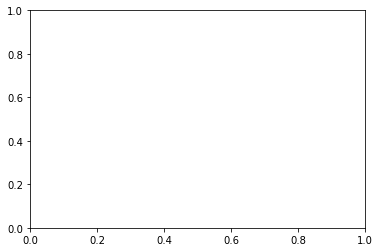

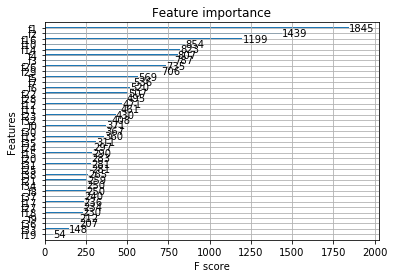

In [36]:
from matplotlib import pyplot as plt

xgb.plot_importance(bst)

plt.show()